In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.1 MB/s eta 0:00:00


In [3]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')
OUTPUT_EXP21_DIR = DIR + '/output/EXP021/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score
import optuna

In [5]:
def get_f1_score(labels, outputs):
    y_pred = outputs
    y_true = labels
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.80, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        #print("Accuracy score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred>best_thresh).astype(int))

In [6]:
class CFG1:
  ver=17
  model="catboost"
  seed=42

class CFG2:
  ver=19
  model="lightgbm"
  seed=42

class CFG3:
  ver=20
  model="xgboost"
  seed=42

class CFG4:
  ver=21
  model="microsoft/deberta-v3-base"
  seed=42

class CFG5:
  ver=41
  model="catboost"
  seed=42

In [7]:
oof_df1 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG1.model}_ver{CFG1.ver}.csv'))
oof_df1.rename(columns={"pred":"pred1"},inplace=True)
oof_df2 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG2.model}_ver{CFG2.ver}.csv'))
oof_df2.rename(columns={"pred":"pred2"},inplace=True)
oof_df3 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG3.model}_ver{CFG3.ver}.csv'))
oof_df3.rename(columns={"pred":"pred3"},inplace=True)
oof_df4 = pd.read_pickle(OUTPUT_EXP21_DIR+'oof_df.pkl')
oof_df4.rename(columns={"pred":"pred4"},inplace=True)
oof_df5 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG5.model}_ver{CFG5.ver}.csv'))
oof_df5.rename(columns={"pred":"pred5"},inplace=True)

In [8]:
oof_df = oof_df1.merge(oof_df2[["index","pred2"]], how="left", on="index").merge(oof_df3[["index","pred3"]], how="left", on="index").merge(oof_df4[["index","pred4"]], how="left", on="index").merge(oof_df5[["index","pred5"]], how="left", on="index")

oof_df["model1"] = oof_df["pred1"].values
oof_df["model2"] = oof_df["pred2"].values
oof_df["model3"] = oof_df["pred3"].values
oof_df["model4"] = oof_df["pred4"].values
oof_df["model5"] = oof_df["pred5"].values

In [9]:
preds_df = oof_df[["is_fraud?","model1","model2","model3","model4","model5"]].copy()
display(preds_df.corr())
print(preds_df.shape)
preds_df.dropna(axis=0,inplace=True)
print(preds_df.shape)
y_true = preds_df["is_fraud?"].values
preds_df.drop("is_fraud?",axis=1,inplace=True)

,is_fraud?,model1,model2,model3,model4,model5
is_fraud?,1.000000,0.705449,0.706214,0.686727,0.574390,0.572585
model1,0.705449,1.000000,0.955161,0.950477,0.795545,0.795389
model2,0.706214,0.955161,1.000000,0.948713,0.785123,0.780226
model3,0.686727,0.950477,0.948713,1.000000,0.815857,0.790588
model4,0.574390,0.795545,0.785123,0.815857,1.000000,0.703650
model5,0.572585,0.795389,0.780226,0.790588,0.703650,1.000000


(471283, 6)
(471283, 6)


In [10]:
for i in range(5):
  score = get_f1_score(y_true, preds_df[f"model{i+1}"])
  print(f"model{i} : {score}")

model0 : 0.6689264376080666
model1 : 0.6709376042709377
model2 : 0.6451733514615908
model3 : 0.5356618952764782
model4 : 0.6546645856191373


In [11]:
SEED = 42
np.random.seed(SEED)

n_models = preds_df.shape[1]
max_iter = 150

In [12]:
def calc_f1_score(weight = np.ones(n_models)):
    y_pred_blended = np.average(preds_df, axis = 1, weights = weight)
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.801, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred_blended>thresh).astype(int))
        # print("F1 score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred_blended>best_thresh).astype(int))

In [13]:
class Objective:
    def __init__(self, n_models):
        self.n_models = n_models

    def __call__(self, trial):
        weight = [trial.suggest_uniform('weight' + str(n), -1, 1) for n in range(self.n_models)]
        return calc_f1_score(weight)
objective = Objective(n_models)

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(sampler = sampler,direction='maximize')
study.optimize(objective, n_trials = max_iter, n_jobs = -1)

[I 2023-08-31 09:18:51,752] A new study created in memory with name: no-name-e0e06bd6-c39e-4285-bc53-e4192835770a
<ipython-input-13-d2ebc12aa7df>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight = [trial.suggest_uniform('weight' + str(n), -1, 1) for n in range(self.n_models)]
[I 2023-08-31 09:19:24,539] Trial 0 finished with value: 0.5823450134770888 and parameters: {'weight0': -0.8192675727664198, 'weight1': 0.6658841653707812, 'weight2': 0.7307464591488071, 'weight3': -0.1660178348842376, 'weight4': -0.06401024685689305}. Best is trial 0 with value: 0.5823450134770888.
<ipython-input-13-d2ebc12aa7df>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight = [trial.suggest_uniform('weight' + str(n

In [14]:
best_weight = list(study.best_params.values())
best_weight = np.array(best_weight) / np.sum(best_weight)
best_score = study.best_value
print('best score: {0}\nbest weight: {1}'.format(best_score, best_weight))

best score: 0.6793602177981963
best weight: [ 0.20903266  0.49440631 -0.05093897  0.03101646  0.31648354]


In [15]:
oof_pred = preds_df["model1"]*best_weight[0] + preds_df["model2"]*best_weight[1] + preds_df["model3"]*best_weight[2] + preds_df["model4"]*best_weight[3] + preds_df["model5"]*best_weight[4]

In [16]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (oof_pred>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(y_true, (oof_pred>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.4237796153208923
F1 score at threshold 0.16 is 0.44036435869229734
F1 score at threshold 0.17 is 0.45639421521203427
F1 score at threshold 0.18 is 0.4719654532526318
F1 score at threshold 0.19 is 0.48668768690090075
F1 score at threshold 0.2 is 0.5011931828858115
F1 score at threshold 0.21 is 0.5148126463700234
F1 score at threshold 0.22 is 0.5277699122203795
F1 score at threshold 0.23 is 0.5412871920098097
F1 score at threshold 0.24 is 0.5540019077349984
F1 score at threshold 0.25 is 0.5667559660587582
F1 score at threshold 0.26 is 0.5781948891020676
F1 score at threshold 0.27 is 0.5884505703422053
F1 score at threshold 0.28 is 0.5989141706826084
F1 score at threshold 0.29 is 0.6074704373396734
F1 score at threshold 0.3 is 0.6164562807881773
F1 score at threshold 0.31 is 0.6248703166244238
F1 score at threshold 0.32 is 0.6322722577702656
F1 score at threshold 0.33 is 0.6388637795491275
F1 score at threshold 0.34 is 0.6446723885283651
F1 score at thresho

In [17]:
class CFG:
  ver=47
  model="blending"

In [18]:
test_pred1 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG1.model}_ver{CFG1.ver}.csv'),header=None)[1]
test_pred2 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG2.model}_ver{CFG2.ver}.csv'),header=None)[1]
test_pred3 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG3.model}_ver{CFG3.ver}.csv'),header=None)[1]
test_pred4 = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_microsoft-deberta-v3-base_seed42_ver21.csv"), header=None)[1]
test_pred5 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG5.model}_ver{CFG5.ver}.csv'))["pred"]

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


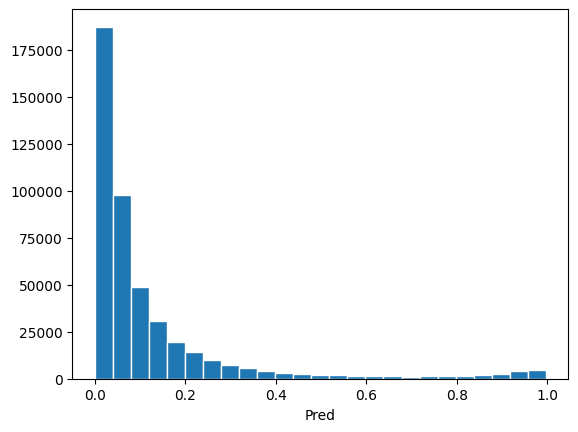

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


In [19]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_pred1*best_weight[0] + test_pred2*best_weight[1] + test_pred3*best_weight[2]  + test_pred4*best_weight[3]  + test_pred5*best_weight[4]
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)

In [20]:
pred

0         0.076351
1         0.232888
2         0.089872
3         0.794362
4         0.029502
            ...   
457953    0.057833
457954    0.039730
457955    0.032662
457956    0.212790
457957    0.034630
Length: 457958, dtype: float64